In [2]:
import cv2

In [4]:
import matplotlib.pyplot as plt

In [14]:
import keras

Using TensorFlow backend.


In [6]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [15]:
face_detector = cv2.CascadeClassifier('C:\\Users\\hunte\\Anaconda3\\envs\\env2\\Library\\etc\\haarcascades\\haarcascade_frontalface_default.xml')

In [139]:
dev = cv2.VideoCapture(0)
numb = 7
try:
    while(True):
        ret, frame = dev.read()
        if (not ret):
            continue
        xSize, ySize, _ = frame.shape
        cv2.imshow("webcam", frame)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow("faces", frame)
        if(cv2.waitKey(1) == ord('a')):
            name = str(numb)+".jpg"
            numb+=1
            plt.imsave(name, frame_gray)
        if (cv2.waitKey(1) == ord('q')):
            break
except Exception as e:
    print(e)

dev.release()
cv2.destroyAllWindows() 

In [13]:
import os

In [148]:
path = "faces/"
names = []
images = []
for f in os.listdir(path):
    file = path + f
    name = f.split('.')[0]
    names.append(name)
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(im)
    (x,y,w,h) = faces[0]
    face_detected = im[y:y+h, x:x+w]/255
    face_result = cv2.resize(face_detected, (96, 96))
    images.append(face_result)

In [141]:
names

['anna',
 'pasha',
 'serg',
 'serg',
 'serg',
 'serg',
 'serg',
 'serg',
 'serg',
 'sergiy',
 'veronika',
 'volodya']

In [142]:
import numpy as np

In [149]:
train_images = np.stack(images)

In [144]:
train_images.shape

(12, 96, 96)

In [145]:
train_images[2].shape

(96, 96)

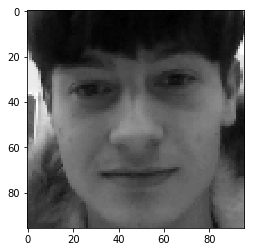

In [172]:
plt.imshow(train_images[2])

In [186]:
Nfaces = train_images.shape[0]

In [187]:
Nfaces

11

In [153]:
def createTrainingSet():
    img_a = []
    img_b = []
    out = []
    for a in range(Nfaces):
        for b in range(Nfaces):
            img_a.append(train_images[a])
            img_b.append(train_images[b])
            out.append(a==b)
    images_a = np.stack(img_a)
    images_b = np.stack(img_b)
    images_a = images_a.reshape(images_a.shape+(1,))
    images_b = images_b.reshape(images_b.shape+(1,))
    return np.stack(images_a), np.stack(images_b), np.stack(out).astype(int)

In [154]:
train = createTrainingSet()

In [180]:
train[0].shape

(121, 96, 96, 1)

In [188]:
def generateBatch():
    gen_a = keras.preprocessing.image.ImageDataGenerator(rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, fill_mode = "constant")
    image_a_gen = gen_a.flow(train[0], batch_size = Nfaces*Nfaces, shuffle = False)
    while(True):
        yield [next(image_a_gen), train[1]], train[2]

In [55]:
def f():
    n = 5
    while(True):
        n+=1
        yield n

In [54]:
x = f()

In [58]:
y = next(x)
print(y)

8


In [189]:
x = generateBatch()
y = next(x)

In [190]:
np.stack(y[0][0]).shape

(121, 96, 96, 1)

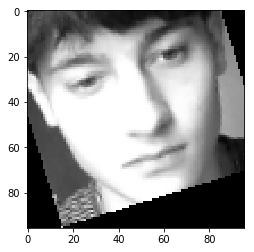

In [167]:
plt.imshow(y[0][0][33].reshape((96,96)))

In [173]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, \
MaxPool2D, UpSampling2D, Concatenate, ReLU, Dropout, Flatten, Subtract, Activation

In [174]:
import keras.backend as K

In [175]:
inp = Input((96, 96, 1))
c1 = Conv2D(16, (3, 3), padding="same", activation = 'relu')(inp)
c1 = Dropout(0.2)(c1)
p1 = MaxPool2D()(c1)
c2 = Conv2D(32, (3, 3), padding = "same", activation='relu')(p1)
c2 = Dropout(0.2)(c2)
p2 = MaxPool2D()(c2)
c3 = Conv2D(48, (3, 3), padding = "same", activation='relu')(p2)
c3 = Dropout(0.2)(c3)
p3 = MaxPool2D()(c3)
c4 = Conv2D(60, (3, 3), padding = "same", activation='relu')(p3)
c4 = Dropout(0.2)(c4)
p4 = MaxPool2D((12, 12))(c4)
res = Flatten()(p4)

feature_model = keras.Model(inp, res)

In [176]:
inp_a = Input((96, 96, 1))
inp_b = Input((96, 96, 1))

feature_a = feature_model(inp_a)
feature_b = feature_model(inp_b)

diff = Subtract()([feature_a, feature_b])
abs_diff = Activation(K.abs)(diff)
point = Dense(1, activation="sigmoid")(abs_diff)

siamese_net = keras.Model([inp_a, inp_b], point)

In [177]:
siamese_net.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy)

In [191]:
siamese_net.fit_generator(generateBatch(), epochs=100, steps_per_epoch=1, shuffle=False)

Epoch 1/100
1/1 [==============================] - 32s 32s/step - loss: 0.7142
Epoch 2/100
1/1 [==============================] - 11s 11s/step - loss: 0.6621
Epoch 3/100
1/1 [==============================] - 9s 9s/step - loss: 0.6217
Epoch 4/100
1/1 [==============================] - 10s 10s/step - loss: 0.5726
Epoch 5/100
1/1 [==============================] - 12s 12s/step - loss: 0.5178
Epoch 6/100
1/1 [==============================] - 11s 11s/step - loss: 0.4531
Epoch 7/100
1/1 [==============================] - 9s 9s/step - loss: 0.4049
Epoch 8/100
1/1 [==============================] - 9s 9s/step - loss: 0.3471
Epoch 9/100
1/1 [==============================] - 9s 9s/step - loss: 0.2939
Epoch 10/100
1/1 [==============================] - 9s 9s/step - loss: 0.2460
Epoch 11/100
1/1 [==============================] - 14s 14s/step - loss: 0.2125
Epoch 12/100
1/1 [==============================] - 13s 13s/step - loss: 0.2001
Epoch 13/100
1/1 [==============================] - 10s 10s

In [192]:
def predict(image):
    image = image.reshape(1, 96, 96, 1)
    image = np.repeat(image, Nfaces, axis=0)
    train_images_new = train_images.reshape(train_images.shape+(1,))
    prediction = siamese_net.predict([image, train_images_new])
    name = "unknown"
    #if(prediction.max()>0.9):
    name = names[np.argmax(prediction)]
    return name

In [196]:
predict(train_images[6])

'serg'

In [197]:
names

['anna',
 'pasha',
 'serg',
 'serg',
 'serg',
 'serg',
 'serg',
 'serg',
 'sergiy',
 'veronika',
 'volodya']

In [198]:
dev = cv2.VideoCapture(0)
try:
    while(True):
        ret, frame = dev.read()
        if (not ret):
            continue
        xSize, ySize, _ = frame.shape
        cv2.imshow("webcam", frame)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(frame_gray)
        if (len(faces)):
            (x,y,w,h) = faces[0]
            cv2.rectangle(frame, (x,y), (x+w, y+h), [0,0,255], 10)
            face = frame_gray[y:y+h, x:x+w]/255
            face_resized = cv2.resize(face, (96, 96))
            name = predict(face_resized)
            cv2.putText(frame, name, (x, y), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 0))
            
        cv2.imshow("faces", frame)
        if (cv2.waitKey(1) == ord('q')):
            break
except Exception as e:
    print(e)

dev.release()
cv2.destroyAllWindows() 